<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Описание-проекта" data-toc-modified-id="Описание-проекта-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Описание проекта</a></span><ul class="toc-item"><li><span><a href="#Описание-данных" data-toc-modified-id="Описание-данных-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Описание данных</a></span></li><li><span><a href="#Общий-датасет" data-toc-modified-id="Общий-датасет-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Общий датасет</a></span></li><li><span><a href="#Вывод:" data-toc-modified-id="Вывод:-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Вывод:</a></span></li></ul></li><li><span><a href="#Target" data-toc-modified-id="Target-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Target</a></span></li><li><span><a href="#Features" data-toc-modified-id="Features-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Features</a></span></li><li><span><a href="#Общая-таблица" data-toc-modified-id="Общая-таблица-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Общая таблица</a></span><ul class="toc-item"><li><span><a href="#Объединение-датасетов" data-toc-modified-id="Объединение-датасетов-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Объединение датасетов</a></span></li><li><span><a href="#Кодирование-категориальных-признаков" data-toc-modified-id="Кодирование-категориальных-признаков-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Кодирование категориальных признаков</a></span></li><li><span><a href="#Test/Train" data-toc-modified-id="Test/Train-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Test/Train</a></span></li></ul></li><li><span><a href="#Модели" data-toc-modified-id="Модели-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Модели</a></span><ul class="toc-item"><li><span><a href="#DummyClassifier" data-toc-modified-id="DummyClassifier-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>DummyClassifier</a></span></li></ul></li></ul></div>

## Описание проекта
Сервис  “Мой Чемпион” помогает спортивным школам фигурного катания, тренерам мониторить результаты своих подопечных и планировать дальнейшее развитие спортсменов.

**Цель**

Создать модель, помогающую находить элементы, которые могут быть успешно исполнены спортсменом на соревновании. 
Сервис будет прогнозировать прогресс и возможное выполнение тех или иных элементов программы по истории предыдущих выступлений и выполнения элементов на соревнованиях.

**Задачи DS**

Объединить данные, провести анализ данных, изучить аномалии, корреляции, описать наблюдения и сделать выводы.
Агрегировать датасет и подготовить обучающие признаки.
Создать модель для предсказания вероятности успешного выполнения элементов.
Проанализировать признаки, выявить ошибки и слабые стороны модели.

In [42]:
# Импорт библиотек

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
#import plotly.express as px
import re

from sklearn.preprocessing import MinMaxScaler, LabelEncoder

In [2]:
from sklearn.model_selection import train_test_split, cross_val_score,  RandomizedSearchCV
#from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import make_scorer, f1_score


In [3]:
from sklearn.dummy import DummyClassifier

In [4]:
import catboost
import time

from tqdm import tqdm
from catboost import CatBoostClassifier

In [5]:
import warnings
warnings.filterwarnings('ignore')

In [6]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

### Описание данных

In [8]:
# Загрузка файла с данными
total_scores = pd.read_csv('data_01_predict_progress/total_scores.csv')
tournament_scores = pd.read_csv('data_01_predict_progress/tournament_scores.csv')
tournaments = pd.read_csv('data_01_predict_progress/tournaments.csv')
units = pd.read_csv('data_01_predict_progress/units.csv')

In [9]:
units.head()

,id,color,school_id
0,9474,green,244.0
1,733,green,203.0
2,734,green,235.0
3,735,green,168.0
4,736,green,168.0


**units** - 
Юнит – спортивная единица. Мы работаем с одиночным катанием, в одном юните только один спортсмен. Если бы были пары/команды, то было б несколько спортсменов в юните.
- id: идентификатор юнита
- color: категория
- school_id: идентификатор школы

В датесете содержатся пропуски в столбцах 'school_id' и 'color' 

In [10]:
units.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4596 entries, 0 to 4595
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   id         4596 non-null   int64  
 1   color      4595 non-null   object 
 2   school_id  4007 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 107.8+ KB


In [11]:
units['color'].unique()

array(['green', 'lime', nan], dtype=object)

In [12]:
units['color'].value_counts()

color
green    3800
lime      795
Name: count, dtype: int64

In [13]:
units['school_id'].value_counts()

school_id
62.0       348
198.0      345
111.0      255
38.0       241
192.0      124
93.0        80
64.0        78
257.0       77
254.0       66
27.0        62
256.0       62
25.0        59
89.0        57
49.0        57
63.0        56
277.0       53
30.0        49
251.0       46
223.0       46
156.0       44
164.0       41
276.0       40
24.0        40
253.0       36
94.0        36
90.0        36
152.0       33
128.0       31
79.0        30
272.0       30
5.0         29
82.0        28
135.0       27
61.0        26
285.0       26
275.0       25
274.0       23
244.0       23
201.0       23
171.0       22
212.0       22
75.0        22
279.0       21
96.0        21
284.0       20
278.0       20
105.0       19
4.0         19
15.0        19
29.0        19
17.0        19
270.0       19
252.0       18
282.0       18
224.0       18
206.0       18
280.0       17
190.0       17
176.0       17
199.0       16
139.0       16
229.0       16
249.0       16
40.0        16
286.0       15
215.0       15


In [14]:
tournaments.head()

,id,date_start,date_end,origin_id
0,1,2090-11-29,2090-12-01,2.0
1,2,2091-03-06,2091-03-10,1.0
2,3,2090-10-05,2090-10-08,2.0
3,4,2090-10-18,2090-10-21,2.0
4,5,2090-10-21,2090-10-24,2.0


**tournaments** -
Турнир состоит из нескольких категорий, оценки по категориям расписаны в total_scores
- id: идентификатор турнира
- date_start: дата начала
- date_end: дата завершения
- origin_id: место проведения

In [15]:
tournaments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142 entries, 0 to 141
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id          142 non-null    int64  
 1   date_start  142 non-null    object 
 2   date_end    142 non-null    object 
 3   origin_id   142 non-null    float64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.6+ KB


In [16]:
total_scores.head()

,id,unit_id,tournament_id,base_score,components_score,total_score,elements_score,decreasings_score,starting_place,place,segment_name,info,overall_place,overall_total_score,overall_place_str
0,442027,304,4785,47.2,43.47,102.70,59.23,0.0,17,1,Короткая программа,x Надбавка за прыжки во второй половине програ...,2,293.74,2
1,442028,604,4785,45.4,46.71,101.19,54.48,0.0,18,2,Короткая программа,q Прыжок приземлён в четверть x Надбавка за пр...,1,294.75,1
2,442029,409,4785,44.0,46.82,99.20,52.38,0.0,6,3,Короткая программа,q Прыжок приземлён в четверть x Надбавка за пр...,4,285.57,4
3,442030,524,4785,46.2,44.86,91.84,47.98,-1.0,3,4,Короткая программа,q Прыжок приземлён в четверть x Надбавка за пр...,3,292.42,3
4,442031,412,4785,44.2,42.59,89.73,48.14,-1.0,15,5,Короткая программа,q Прыжок приземлён в четверть x Надбавка за пр...,6,265.34,6


In [17]:
total_scores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21301 entries, 0 to 21300
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   21301 non-null  int64  
 1   unit_id              21301 non-null  int64  
 2   tournament_id        21301 non-null  int64  
 3   base_score           21301 non-null  float64
 4   components_score     21301 non-null  float64
 5   total_score          21301 non-null  float64
 6   elements_score       21301 non-null  float64
 7   decreasings_score    21301 non-null  float64
 8   starting_place       21301 non-null  int64  
 9   place                21301 non-null  int64  
 10  segment_name         21284 non-null  object 
 11  info                 20720 non-null  object 
 12  overall_place        21301 non-null  int64  
 13  overall_total_score  21284 non-null  float64
 14  overall_place_str    10814 non-null  object 
dtypes: float64(6), int64(6), object(3)
m

**total_scores** - Оценки за выступления по категориям и общие за турнир
- id: идентификатор выступления, джойнится с tournament_scores.total_score_id
- unit_id: идентификатор юнита, ключ к units.id
- tournament_id: идентификатор турнира, tournaments.id
- components_score: артистизм (мастерство, композиция, хореография)
- base_score: базовая оценка за элементы в выступлении (идеал)
- elements_score: реальная оценка всех выполненных элементов, base_score+goe
- decreasings_score: снижения оценок за ошибки
- total_score: components_score+elements_score+decreasings_score за выступление
- starting_place: жеребъёвка
- place: занятое место в категории category_name+segment_name
- segment_name: название сегмента
- info: комментарии и пояснения к оценке
- overall_place: итоговое место в турнире
- overall_total_score: итоговая оценка за весь турнир
- overall_place_str: комментарии, пояснения

In [18]:
tournament_scores.head()

,id,total_score_id,title,decrease,base_score,goe,avg_score
0,1,1,2A,NaN,3.3,0.66,3.96
1,2,1,3F+3Lo,NaN,10.2,-0.11,10.09
2,3,1,3Lz,NaN,0.0,-1.30,5.19
3,4,1,CCoSp4,NaN,3.5,0.56,4.06
4,5,1,FCSp4,NaN,3.2,0.64,3.84


In [19]:
# выполняемые элементы
tournament_scores['title'].value_counts().head(100)

title
CCoSp4        8687
2A            8500
ChSq1         8301
CCoSp3        6064
StSq2         5097
LSp4          4551
3Lo           3904
1A            3379
2Lz           3266
2F            2967
3Lz           2882
FCSp4         2802
FSSp3         2753
StSq1         2725
LSp3          2641
FSSp4         2606
3F            2468
3S            2240
StSqB         2095
StSq3         1943
2S            1914
CCoSp2        1779
2Lo           1776
2A<<          1767
FSSp2         1694
3Lz+3T        1685
FCSp3         1674
1Lz           1644
FCCoSp4       1600
ChSpl1        1588
CSSp4         1578
2A<           1252
2Lz+2Lo       1241
3Lz+2T        1115
LSp2          1058
3S+2T         1018
CSSp3          977
3T             977
2Lz+2T         964
CCoSp1         942
3A             911
SSpB           856
3F+2T          851
3Lo<           830
3Lo+2T         820
2F+2Lo         805
3S<            794
2Lz<           752
FCSp2          750
2A+2T          724
2F<            711
2F!            683
FSSp1 

In [20]:
tournament_scores['title'].nunique()

3425

In [21]:
tournament_scores['decrease'].unique()

array([nan, 'q', '<', '!', '<<', 'nS', 'F', '*', 'e', 'nU', 'nC', '<<*',
       '<*', 'B', 'nS*', '!F', 'F*', '!*', 'q*', 'e*', 'nF', 'nB', 'B.',
       'f*', 'В', '<F', 'qF', 'b', '!<', 'f', '!F*', 'FnU', 'FF'],
      dtype=object)

- '*' - элемент не засчитывается
- q - недокручена четверть
- < - недокручено 90-180 градусов
- << - недокручено больше 180 градусов
- e  - отталкивание не с того ребра
- ! - толчок не с точного ребра
- F - упал
- B - bonus 
- nU, nC, nS, nF, nB - ошибки во вращениях

**tournament_scores** - Таблица с оценками поэлементно
- id: идентификатор оценки за конкретный элемент/комбинацию
- total_score_id: идентикатор выступления, ключ total_scores.id
- title: запись элемента или комбинации элементов с отметками об ошибках
- decrease: за что снижена оценка
- base_score: базовая оценка (идеал, цена данного элемента/комбинации, сложность)
- goe: Grade of Execute, качество исполнения, судейские надбавки/убавки
- avg_score: оценка за элемент/комбинацию (усредненная по судьям)

In [23]:
tournament_scores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 172158 entries, 0 to 172157
Data columns (total 7 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   id              172158 non-null  int64  
 1   total_score_id  172158 non-null  int64  
 2   title           172158 non-null  object 
 3   decrease        41185 non-null   object 
 4   base_score      172158 non-null  float64
 5   goe             172158 non-null  float64
 6   avg_score       172158 non-null  float64
dtypes: float64(3), int64(2), object(2)
memory usage: 9.2+ MB


В 'decrease'  много пропусков - это связано с тем, что замечаней по выполнению элементов не было

В 'base_score'  - базовая оценка много полей заполненных нулями - исправим это, рассчитав 'base_score' как 'avg_score'-'goe'

In [24]:
tournament_scores['base_score'] = tournament_scores['avg_score'] - tournament_scores['goe']

In [25]:
tournament_scores.head(20)

,id,total_score_id,title,decrease,base_score,goe,avg_score
0,1,1,2A,NaN,3.30,0.66,3.96
1,2,1,3F+3Lo,NaN,10.20,-0.11,10.09
2,3,1,3Lz,NaN,6.49,-1.30,5.19
3,4,1,CCoSp4,NaN,3.50,0.56,4.06
4,5,1,FCSp4,NaN,3.20,0.64,3.84
5,6,1,LSp4,NaN,2.70,0.49,3.19
6,7,1,StSq2,NaN,2.60,0.26,2.86
7,8,8,2A,NaN,3.30,0.53,3.83
8,9,8,3F,NaN,5.83,0.42,6.25
9,10,8,3Fq+3Loq,q,10.20,-1.91,8.29


###  Общий датасет
Объединим таблицы: units и total_scores

In [26]:
# объединим units и total_scores по ключу unit_id
df = pd.merge(
    units, total_scores,
    left_on='id',
    right_on='unit_id'
)

In [27]:
df.sort_values('id_x', ascending=True).head()

,id_x,color,school_id,id_y,unit_id,tournament_id,base_score,components_score,total_score,elements_score,decreasings_score,starting_place,place,segment_name,info,overall_place,overall_total_score,overall_place_str
12334,1,green,198.0,7556,1,33,30.61,22.81,52.67,31.86,0.0,17,13,Короткая программа,< Недокрученный прыжок x Надбавка за прыжки во...,15,140.43,NaN
12337,1,green,198.0,10342,1,52,52.46,52.74,95.61,47.87,0.0,6,14,Произвольная программа,q Прыжок приземлён в четверть < Недокрученный ...,14,151.55,NaN
12336,1,green,198.0,441807,1,4790,52.39,55.65,111.05,55.40,0.0,28,11,Произвольная программа,q Прыжок приземлён в четверть x Надбавка за пр...,10,170.40,10
12335,1,green,198.0,7576,1,33,48.03,43.79,87.76,44.97,0.0,6,15,Произвольная программа,< Недокрученный прыжок << Пониженный прыжок x ...,15,140.43,NaN
12333,1,green,198.0,6094,1,21,59.26,55.67,118.09,62.42,0.0,5,4,Произвольная программа,q Прыжок приземлён в четверть < Недокрученный ...,4,174.38,NaN


In [28]:
# удалим столбец 'id_x' дублирующий 'unit_id'
df = df.drop(["id_x"], axis=1)

In [29]:
# переименуем столбец 'id_y'  в 'total_score_id'
df = df.rename(columns = {'id_y':'total_score_id'})

Добавим таблицу tournaments по ключу 'tournament_id'

In [30]:
df = pd.merge(
    df, tournaments,
    left_on='tournament_id',
    right_on='id'
)

In [31]:
df.head()

,color,school_id,total_score_id,unit_id,tournament_id,base_score,components_score,total_score,elements_score,decreasings_score,starting_place,place,segment_name,info,overall_place,overall_total_score,overall_place_str,id,date_start,date_end,origin_id
0,green,244.0,442068,9474,4785,31.73,33.87,68.40,35.53,-1.0,1,9,Короткая программа,x Надбавка за прыжки во второй половине програ...,18,164.30,18,4785,2091-12-20,2091-12-24,2.0
1,green,244.0,442094,9474,4785,46.05,61.33,95.90,40.57,-6.0,10,18,Произвольная программа,* Недопустимый элемент < Недокрученный прыжок ...,18,164.30,18,4785,2091-12-20,2091-12-24,2.0
2,green,203.0,5246,733,17,22.40,21.64,42.70,21.06,0.0,18,16,Короткая программа,< Недокрученный прыжок x Надбавка за прыжки во...,17,107.00,NaN,17,2090-12-09,2090-12-12,2.0
3,green,203.0,5271,733,17,32.98,36.93,64.30,28.37,0.0,8,18,Произвольная программа,< Недокрученный прыжок << Пониженный прыжок e ...,17,107.00,NaN,17,2090-12-09,2090-12-12,2.0
4,green,235.0,442856,734,4793,21.95,22.76,41.76,21.00,-2.0,14,29,Короткая программа,< Недокрученный прыжок << Пониженный прыжок x ...,25,121.41,25,4793,2091-12-09,2091-12-11,2.0


In [32]:
# удалим колонку 'id' дублирующую 'tournament_id'
df = df.drop(["id"], axis=1)

In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21301 entries, 0 to 21300
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   color                21301 non-null  object 
 1   school_id            20384 non-null  float64
 2   total_score_id       21301 non-null  int64  
 3   unit_id              21301 non-null  int64  
 4   tournament_id        21301 non-null  int64  
 5   base_score           21301 non-null  float64
 6   components_score     21301 non-null  float64
 7   total_score          21301 non-null  float64
 8   elements_score       21301 non-null  float64
 9   decreasings_score    21301 non-null  float64
 10  starting_place       21301 non-null  int64  
 11  place                21301 non-null  int64  
 12  segment_name         21284 non-null  object 
 13  info                 20720 non-null  object 
 14  overall_place        21301 non-null  int64  
 15  overall_total_score  21284 non-null 

Добавим таблицу tournament_scores по ключу 'total_score_id'

In [34]:
df = pd.merge(
    df, tournament_scores,
    left_on='total_score_id',
    right_on='total_score_id'
)

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 172158 entries, 0 to 172157
Data columns (total 26 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   color                172158 non-null  object 
 1   school_id            164913 non-null  float64
 2   total_score_id       172158 non-null  int64  
 3   unit_id              172158 non-null  int64  
 4   tournament_id        172158 non-null  int64  
 5   base_score_x         172158 non-null  float64
 6   components_score     172158 non-null  float64
 7   total_score          172158 non-null  float64
 8   elements_score       172158 non-null  float64
 9   decreasings_score    172158 non-null  float64
 10  starting_place       172158 non-null  int64  
 11  place                172158 non-null  int64  
 12  segment_name         172115 non-null  object 
 13  info                 168356 non-null  object 
 14  overall_place        172158 non-null  int64  
 15  overall_total_sco

In [36]:
#количество уникальных значений 'origin_id' -место проведения
df['origin_id'].value_counts()

origin_id
2.0    78204
1.0    55240
0.0    38714
Name: count, dtype: int64

In [37]:
print('Количество турниров:', df['tournament_id'].nunique())

Количество турниров: 142


In [38]:
print('Количество записей по каждому турниру:')
df['tournament_id'].value_counts()

Количество записей по каждому турниру:


tournament_id
6859    4314
78      4223
7114    4045
6848    3660
77      3398
7098    3041
7117    2860
85      2853
7103    2838
79      2786
7110    2769
88      2749
7106    2635
6864    2634
6866    2433
2       2363
24      2255
39      2229
76      2222
68      2218
6699    2203
6885    2011
7092    1982
18      1909
3       1885
14      1873
4992    1863
176     1850
47      1767
40      1728
7111    1724
4790    1709
4793    1638
17      1617
45      1588
48      1550
7109    1547
73      1519
398     1484
6847    1454
84      1430
4789    1412
6845    1410
6160    1403
21      1399
5879    1377
51      1337
177     1296
7115    1281
4794    1266
52      1265
23      1257
4865    1247
33      1245
1       1221
69      1180
91      1160
6850    1159
6849    1155
49      1155
7112    1116
7104    1032
72      1019
222     1009
92      1008
44      1008
263     1001
6676     999
6844     987
43       975
29       960
50       957
2616     948
86       940
22       936
95       93

In [39]:
print('Количество записей по каждому участнику:')
df["unit_id"].value_counts()

Количество записей по каждому участнику:


unit_id
351      442
350      411
354      365
310      363
313      363
        ... 
9526       2
9533       2
9532       2
9521       2
10015      1
Name: count, Length: 3393, dtype: int64

In [40]:
print('Количество турниров для каждого участника')
display(df.groupby('unit_id')['tournament_id'].nunique())

Количество турниров для каждого участника


unit_id
1        15
3        12
4         6
5         6
6        12
         ..
35003     1
35004     1
35005     1
35006     1
35024     1
Name: tournament_id, Length: 3393, dtype: int64

В данных присутствуют спортсмены, принимавшие участие только в одном соревновании.

### Вывод: 
Нам предоставлены несколько таблиц в которых хранятся данные по каждому спортсмену: в каких турнирах участвовал, какие элементы выполнял, какие ошибки были, сколько баллов набрал, какие места в каком сегменте завоёвывал.

В данных есть информация о 3393 спортсменах. Количество турниров: 142 в трёх различных местах.

Все датасеты были соединины в один.

В данных присутствуют пропуски в столбцах: 
- 'school_id' - идентификатор школы, восстановить невозможно
- 'info' - комментарии к выступлению, восстановить невозможно
- 'segment_name' - название сегмента, восстановить невозможно
- 'overall_total_score' - итоговая оценка за весь,  турнир,восстановить невозможно
- 'overall_place_str', восстановить невозможно
- 'decrease' - за что снижена оценка. Это связано с тем, что замечаней по выполнению элементов не было. Именно исходя из этих данным будем выбирать элементы выполненные без ошибок. (таргет)

## Target

Создадим новый датасет с таргетом исходя из имеющихся данных: для каждого спортсмена выберем элементы, которые он выполнял без ошибок.

In [43]:
# Функция для извлечения элементов из строки
def extract_elements(text):
    # Паттерн для совпадения элементов, исключая строчную 'e', заглавные 'V' и 'B', и 'q' после 'A', 'T', 'F'
    pattern = r'\b\d*[A-Z][a-zA-Z]*\d*\b'
    # Находим все совпадения
    matches = re.findall(pattern, text)
    # Удаляем 'e' внутри каждого совпадения и обрабатываем случаи с V или B в конце элемента
    final_matches = []
    for match in matches:
        # Убираем 'e'
        match = re.sub(r'e', '', match)
        # Удаляем V или B в конце элемента
        match = re.sub(r'[B]$', '', match)
        match = re.sub(r'[V]$', '', match)
        if re.search(r'[ATFo]q', match):
            # Убираем "q" после "A", "T", "F"
            final_matches.append(re.sub(r'q', '', match))
        else:
            final_matches.append(match)
    return final_matches


# Применение функции к каждому элементу столбца
df['list_title'] = df['title'].apply(extract_elements)

df['list_title'] = df['list_title'].apply(lambda x: [item for item in x if item not in ['COMBO', 'REP']])

In [44]:
df.head()

,color,school_id,total_score_id,unit_id,tournament_id,base_score_x,components_score,total_score,elements_score,decreasings_score,starting_place,place,segment_name,info,overall_place,overall_total_score,overall_place_str,date_start,date_end,origin_id,id,title,decrease,base_score_y,goe,avg_score,list_title
0,green,244.0,442068,9474,4785,31.73,33.87,68.4,35.53,-1.0,1,9,Короткая программа,x Надбавка за прыжки во второй половине програ...,18,164.3,18,2091-12-20,2091-12-24,2.0,156595,3Lz+3T,NaN,10.10,1.18,11.28,"[3Lz, 3T]"
1,green,244.0,442068,9474,4785,31.73,33.87,68.4,35.53,-1.0,1,9,Короткая программа,x Надбавка за прыжки во второй половине програ...,18,164.3,18,2091-12-20,2091-12-24,2.0,156596,2A,NaN,3.30,0.85,4.15,[2A]
2,green,244.0,442068,9474,4785,31.73,33.87,68.4,35.53,-1.0,1,9,Короткая программа,x Надбавка за прыжки во второй половине програ...,18,164.3,18,2091-12-20,2091-12-24,2.0,156597,FCSp4,NaN,3.20,0.87,4.07,[FCSp4]
3,green,244.0,442068,9474,4785,31.73,33.87,68.4,35.53,-1.0,1,9,Короткая программа,x Надбавка за прыжки во второй половине програ...,18,164.3,18,2091-12-20,2091-12-24,2.0,156598,3F,NaN,5.83,-1.36,4.47,[3F]
4,green,244.0,442068,9474,4785,31.73,33.87,68.4,35.53,-1.0,1,9,Короткая программа,x Надбавка за прыжки во второй половине програ...,18,164.3,18,2091-12-20,2091-12-24,2.0,156599,SSp4,NaN,2.50,0.61,3.11,[SSp4]


In [45]:
# для 'unit_id' = 1  выведем данные
df.query('unit_id == 1')

,color,school_id,total_score_id,unit_id,tournament_id,base_score_x,components_score,total_score,elements_score,decreasings_score,starting_place,place,segment_name,info,overall_place,overall_total_score,overall_place_str,date_start,date_end,origin_id,id,title,decrease,base_score_y,goe,avg_score,list_title
100447,green,198.0,442658,1,4844,28.96,28.00,60.70,32.70,0.0,4,3,Короткая программа,! Неясное ребро на толчке F/Lz x Надбавка за п...,3,183.24,3,2091-12-25,2091-12-26,1.0,161036,2A,NaN,3.30,0.59,3.89,[2A]
100448,green,198.0,442658,1,4844,28.96,28.00,60.70,32.70,0.0,4,3,Короткая программа,! Неясное ребро на толчке F/Lz x Надбавка за п...,3,183.24,3,2091-12-25,2091-12-26,1.0,161037,3F!,!,5.30,0.11,5.41,[3F]
100449,green,198.0,442658,1,4844,28.96,28.00,60.70,32.70,0.0,4,3,Короткая программа,! Неясное ребро на толчке F/Lz x Надбавка за п...,3,183.24,3,2091-12-25,2091-12-26,1.0,161038,LSp4,NaN,2.70,0.49,3.19,[LSp4]
100450,green,198.0,442658,1,4844,28.96,28.00,60.70,32.70,0.0,4,3,Короткая программа,! Неясное ребро на толчке F/Lz x Надбавка за п...,3,183.24,3,2091-12-25,2091-12-26,1.0,161039,3Lz+2Lo,NaN,8.36,0.83,9.19,"[3Lz, 2Lo]"
100451,green,198.0,442658,1,4844,28.96,28.00,60.70,32.70,0.0,4,3,Короткая программа,! Неясное ребро на толчке F/Lz x Надбавка за п...,3,183.24,3,2091-12-25,2091-12-26,1.0,161040,FCSp4,NaN,3.20,0.64,3.84,[FCSp4]
100452,green,198.0,442658,1,4844,28.96,28.00,60.70,32.70,0.0,4,3,Короткая программа,! Неясное ребро на толчке F/Lz x Надбавка за п...,3,183.24,3,2091-12-25,2091-12-26,1.0,161041,StSq2,NaN,2.60,0.52,3.12,[StSq2]
100453,green,198.0,442658,1,4844,28.96,28.00,60.70,32.70,0.0,4,3,Короткая программа,! Неясное ребро на толчке F/Lz x Надбавка за п...,3,183.24,3,2091-12-25,2091-12-26,1.0,161042,CCoSp4,NaN,3.50,0.56,4.06,[CCoSp4]
100454,green,198.0,442666,1,4844,59.07,57.41,122.54,65.13,0.0,6,3,Произвольная программа,q Прыжок приземлён в четверть x Надбавка за пр...,3,183.24,3,2091-12-25,2091-12-26,1.0,161102,3T,NaN,4.20,0.76,4.96,[3T]
100455,green,198.0,442666,1,4844,59.07,57.41,122.54,65.13,0.0,6,3,Произвольная программа,q Прыжок приземлён в четверть x Надбавка за пр...,3,183.24,3,2091-12-25,2091-12-26,1.0,161103,3Lz+2T,NaN,7.20,0.83,8.03,"[3Lz, 2T]"
100456,green,198.0,442666,1,4844,59.07,57.41,122.54,65.13,0.0,6,3,Произвольная программа,q Прыжок приземлён в четверть x Надбавка за пр...,3,183.24,3,2091-12-25,2091-12-26,1.0,161104,2A,NaN,3.30,0.59,3.89,[2A]


Из данных о соревнованиях по фигурному катанию составим список элементов, исмолняемых спортсменами

In [46]:
# cписок элементов
elements = ["USp", "LSp", "LSp1",'LSp2', 'LSp3', 'LSp4',
                "CSp", "CSp1", "CSp2", "CSp3", "CSp4",
                "SSp", "SSp1",  "SSp2", "SSp3", "SSp4",
                "FUSp",
                "FLSp1", 
                "FCSp", "FCSp1", "FCSp2", "FCSp3", "FCSp4",
                "FSSp", "FSSp1", "FSSp2", "FSSp3", "FSSp4", 
                "CUSp", 
                "CLSp",
                "CCSp", "CCSp1", "CCSp2", "CCSp3", "CCSp4", 
                "CSSp", "CSSp1", "CSSp2", "CSSp3", "CSSp4", 
                "CoSp", "CoSp1", "CoSp2", 
                "CCoSp", "CCoSp1", "CCoSp2", "CCoSp3", "CCoSp4", 
                "StSq", "StSq1", "StSq2", "StSq3", "StSq4", 
                "ChSq", "ChSq1",
                "T", "1T", "2T", "3T", "4T", 
                "S", "1S", "2S", "3S", "4S", 
                "Lo", "1Lo", "2Lo", "3Lo", "4Lo", 
                "F", "1F", "2F", "3F", "4F", 
                "Lz", "1Lz", "2Lz", "3Lz", "4Lz", 
                "A", "1A", "2A", "3A", "4A",
                "1Eu"]

In [47]:
# Создание списка для накопления данных
rows = []

# Заполнение таблицы
for unit_id in df['unit_id'].unique():
    # Получаем все записи для данного unit_id
    unit_records = df[df['unit_id'] == unit_id]
    decrease_value = unit_records['decrease'].iloc[0]  # Берем значение decrease из первой записи
    
    # Инициализация словаря для данного unit_id
    unit_dict = {'unit_id': unit_id}
    for target in elements:
        # Если 'decrease' равно NaN, устанавливаем значение 1 для всех таргетов
        if pd.isna(decrease_value):
            unit_dict[target] = 1 if any(target in lst for lst in unit_records['list_title']) else 0
        # Если 'decrease' не равно NaN, устанавливаем значение 0 для всех фичей
        else:
            unit_dict[target] = 0
    
    # Добавляем словарь в список
    rows.append(unit_dict)

# Преобразование списка словарей в DataFrame
target_df = pd.DataFrame(rows)

In [48]:
target_df.head(10)

,unit_id,USp,LSp,LSp1,LSp2,LSp3,LSp4,CSp,CSp1,CSp2,CSp3,CSp4,SSp,SSp1,SSp2,SSp3,SSp4,FUSp,FLSp1,FCSp,FCSp1,FCSp2,FCSp3,FCSp4,FSSp,FSSp1,FSSp2,FSSp3,FSSp4,CUSp,CLSp,CCSp,CCSp1,CCSp2,CCSp3,CCSp4,CSSp,CSSp1,CSSp2,CSSp3,CSSp4,CoSp,CoSp1,CoSp2,CCoSp,CCoSp1,CCoSp2,CCoSp3,CCoSp4,StSq,StSq1,StSq2,StSq3,StSq4,ChSq,ChSq1,T,1T,2T,3T,4T,S,1S,2S,3S,4S,Lo,1Lo,2Lo,3Lo,4Lo,F,1F,2F,3F,4F,Lz,1Lz,2Lz,3Lz,4Lz,A,1A,2A,3A,4A,1Eu
0,9474,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,1,1,0,0,1,0,0,1,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,1,0,0,0,0,1,0,0,0,1,0,0,1
1,733,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0
2,734,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,735,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,1,0,0,0
4,736,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,737,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,1,0,0,1,1,0,0,0,0,1,0,0,0,1,0,0,0,1,1,1,0,0,0,1,1,0,0,0,1,0,0,1
6,738,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1
7,739,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,740,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,1,0,0,0
9,1007,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [49]:
#объединим столбцы с одинаковыми по смыслу элементами: 
target_df['LSp1'] = target_df[['LSp', 'LSp1']].max(axis=1)
target_df['CSp1'] = target_df[['CSp', 'CSp1']].max(axis=1) 
target_df['SSp1'] = target_df[['SSp', 'SSp1']].max(axis=1)
target_df['FCSp1'] = target_df[['FCSp', 'FCSp1']].max(axis=1)
target_df['FSSp1'] = target_df[['FSSp', 'FSSp1']].max(axis=1)
target_df['CCSp1'] = target_df[['CCSp', 'CCSp1']].max(axis=1)
target_df['CSSp1'] = target_df[['CSSp', 'CSSp1']].max(axis=1)
target_df['CoSp1'] = target_df[['CoSp', 'CoSp1']].max(axis=1)
target_df['CCoSp1'] = target_df[['CCoSp', 'CCoSp1']].max(axis=1)
target_df['StSq1'] = target_df[['StSq', 'StSq1']].max(axis=1)
target_df['ChSq'] = target_df[['ChSq', 'ChSq1']].max(axis=1)
target_df['1T'] = target_df[['T', '1T']].max(axis=1)
target_df['1S'] = target_df[['S', '1S']].max(axis=1)
target_df['1Lo'] = target_df[['Lo', '1Lo']].max(axis=1)
target_df['1F'] = target_df[['F', '1F']].max(axis=1)
target_df['1Lz'] = target_df[['Lz', '1Lz']].max(axis=1) 
target_df['1A'] = target_df[['A', '1A']].max(axis=1)

In [50]:
target_df = target_df.drop(columns=['LSp', 'CSp', 'SSp', 'FCSp', 'FSSp', 'CCSp', 'CSSp', 'CoSp',
                                       'CCoSp', 'StSq', 'ChSq1', 'T', 'S', 'Lo', 'F', 'Lz', 'A' ])

In [51]:
target_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3393 entries, 0 to 3392
Data columns (total 70 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   unit_id  3393 non-null   int64
 1   USp      3393 non-null   int64
 2   LSp1     3393 non-null   int64
 3   LSp2     3393 non-null   int64
 4   LSp3     3393 non-null   int64
 5   LSp4     3393 non-null   int64
 6   CSp1     3393 non-null   int64
 7   CSp2     3393 non-null   int64
 8   CSp3     3393 non-null   int64
 9   CSp4     3393 non-null   int64
 10  SSp1     3393 non-null   int64
 11  SSp2     3393 non-null   int64
 12  SSp3     3393 non-null   int64
 13  SSp4     3393 non-null   int64
 14  FUSp     3393 non-null   int64
 15  FLSp1    3393 non-null   int64
 16  FCSp1    3393 non-null   int64
 17  FCSp2    3393 non-null   int64
 18  FCSp3    3393 non-null   int64
 19  FCSp4    3393 non-null   int64
 20  FSSp1    3393 non-null   int64
 21  FSSp2    3393 non-null   int64
 22  FSSp3    3393 non-null  

## Features

Создадим новую таблицу с фичами исходя из имеющихся данных.
Для каждого спортсмены определим
- количество турниров, в которых он участвовал
- даты первого и последнего турниров
- категория ('color')
- Лучшее и худшее место в различных сегментах
- Лучший и худший бал за выступление по сегментам
- Максимальное и минимальное значение  Grade of Execute - надбавки за элементы
- Среднее значение среднего бала заэлементы

**Количество турниров, в которых участвовал спортсмен**

In [52]:
feature_df = df.groupby('unit_id')['tournament_id'].nunique().reset_index()

In [53]:
feature_df.rename(columns={'tournament_id': 'count_tournament'}, inplace=True)

**Даты первого и последнего турнира**

In [54]:
# Преобразование столбца 'date_start' в формат datetime, обработка ошибок
df['date_start'] = pd.to_datetime(df['date_start'], errors='coerce')

In [55]:
# первый турнир
first_tournament = df.groupby('unit_id')['date_start'].min().reset_index()
first_tournament.rename(columns={'date_start': 'first_tournament'}, inplace=True)

feature_df = pd.merge(
    feature_df, first_tournament,
    left_on='unit_id',
    right_on='unit_id'
)

In [56]:
# последний турнир
last_tournament = df.groupby('unit_id')['date_start'].max().reset_index()
last_tournament.rename(columns={'date_start': 'last_tournament'}, inplace=True)
feature_df = pd.merge(
    feature_df, last_tournament,
    left_on='unit_id',
    right_on='unit_id'
)

In [57]:
feature_df.head()

,unit_id,count_tournament,first_tournament,last_tournament
0,1,15,2090-04-19,2092-04-23
1,3,12,2090-10-05,2092-04-23
2,4,6,2090-10-26,2091-12-15
3,5,6,2090-10-26,2092-04-14
4,6,12,2090-10-26,2092-04-23


**Категория**

In [59]:
color = df.groupby('unit_id')['color'].max().reset_index()
feature_df = pd.merge(
    feature_df, color,
    left_on='unit_id',
    right_on='unit_id'
)

**Лучшее и худшее место в различных сегментах**

In [60]:
print('Список уникальных названий сегментов:', df['segment_name'].unique())

Список уникальных названий сегментов: ['Короткая программа' 'Произвольная программа' 'Кoроткая программа'
 'Прoизвольная прoграмма' 'Пpoизвольная программа' 'Элементы'
 'Кopoткaя пpoгpaммa' 'Пpoизвoльнaя пpoгpaммa' 'Произвольная программа.'
 'Прыжки' 'Элeмeнты' 'Kopoткaя пpoгpaммa' 'Произвольнaя программа'
 'Коpоткая программа' 'Пpoизвольнaя программа' 'Интерпретация.' nan
 'Интерпретация']


In [61]:
# количество записей для каждого уникального значения сегмента
df['segment_name'].value_counts()

segment_name
Произвольная программа     91935
Короткая программа         53525
Произвольная программа.    17091
Элементы                    3520
Пpoизвoльнaя пpoгpaммa      1581
Прыжки                       852
Кoроткая программа           700
Кopoткaя пpoгpaммa           659
Произвольнaя программа       473
Прoизвольная прoграмма       427
Kopoткaя пpoгpaммa           377
Элeмeнты                     341
Пpoизвольная программа       315
Коpоткая программа           126
Интерпретация.               111
Пpoизвольнaя программа        70
Интерпретация                 12
Name: count, dtype: int64

Приведём значения сегментов к единому написанию

In [62]:
# переименуем значения - пиведём их к единому написанию
df['segment_name'] = df['segment_name'].replace({
    'Пpoизвoльнaя пpoгpaммa': 'Произвольная программа',
    'Произвольная программа.': 'Произвольная программа',
    'Пpoизвольнaя программа': 'Произвольная программа',
    'Пpoизвольная программа': 'Произвольная программа',
    'Прoизвольная прoграмма': 'Произвольная программа',
    'Пpoизвольнaя программа': 'Произвольная программа',
    'Произвольнaя программа': 'Произвольная программа',
    'Kopoткaя пpoгpaммa': 'Короткая программа',
    'Кopoткaя пpoгpaммa': 'Короткая программа',
    'Коpоткая программа': 'Короткая программа',
    'Кoроткая программа': 'Короткая программа',
    'Пpогpaммa': 'Программа',
    'Элeмeнты': 'Элементы',
    'Прыжки': 'Прыжки',
    'Интерпретация.': 'Интерпретация'
})

print(df['segment_name'].unique())

['Короткая программа' 'Произвольная программа' 'Элементы' 'Прыжки'
 'Интерпретация' nan]


In [63]:
# количество записей для каждого уникального значения сегмента
df['segment_name'].value_counts()

segment_name
Произвольная программа    111892
Короткая программа         55387
Элементы                    3861
Прыжки                       852
Интерпретация                123
Name: count, dtype: int64

In [64]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 172158 entries, 0 to 172157
Data columns (total 27 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   color                172158 non-null  object        
 1   school_id            164913 non-null  float64       
 2   total_score_id       172158 non-null  int64         
 3   unit_id              172158 non-null  int64         
 4   tournament_id        172158 non-null  int64         
 5   base_score_x         172158 non-null  float64       
 6   components_score     172158 non-null  float64       
 7   total_score          172158 non-null  float64       
 8   elements_score       172158 non-null  float64       
 9   decreasings_score    172158 non-null  float64       
 10  starting_place       172158 non-null  int64         
 11  place                172158 non-null  int64         
 12  segment_name         172115 non-null  object        
 13  info          

In [65]:
# удалим записи с пропусками: 43 записи
df = df.dropna(subset =['segment_name'])

In [66]:
print(df['segment_name'].unique())

['Короткая программа' 'Произвольная программа' 'Элементы' 'Прыжки'
 'Интерпретация']


In [67]:
# Группировка по 'unit_id' и 'segment_name' и нахождение минимального значения 'place'
best_place = df.groupby(['unit_id', 'segment_name'])['place'].min().unstack().reset_index()

# Переименование столбцов
best_place.columns = ['unit_id', 'best_place_interpretation', 'best_place_short', 'best_place_free', 'best_place_jump', 'best_place_elements']
best_place.head()

,unit_id,best_place_interpretation,best_place_short,best_place_free,best_place_jump,best_place_elements
0,1,NaN,1.0,3.0,NaN,NaN
1,3,NaN,1.0,1.0,NaN,NaN
2,4,NaN,2.0,2.0,NaN,NaN
3,5,NaN,2.0,2.0,NaN,NaN
4,6,NaN,3.0,1.0,NaN,NaN


In [68]:
# заполним пропуски 0
best_place = best_place.fillna(0)

In [69]:
feature_df = pd.merge(
    feature_df, best_place,
    left_on='unit_id',
    right_on='unit_id'
)

In [70]:
# Группировка по 'unit_id' и 'segment_name' и нахождение максимальное значения 'place'
worst_place = df.groupby(['unit_id', 'segment_name'])['place'].max().unstack().reset_index()

# Переименование столбцов
worst_place.columns = ['unit_id', 'worst_place_interpretation', 'worst_place_short', 'worst_place_free', 'worst_place_jump', 'worst_place_elements']

worst_place = worst_place.fillna(0)

feature_df = pd.merge(
    feature_df, worst_place,
    left_on='unit_id',
    right_on='unit_id'
)

**Лучший и худший бал за выступление по сегментам**

In [71]:
# Группировка по 'unit_id' и 'segment_name' и нахождение минимальное значения 'total_score'
worst_total_score = df.groupby(['unit_id', 'segment_name'])['total_score'].min().unstack().reset_index()

# Переименование столбцов
worst_total_score.columns = ['unit_id', 'worst_total_score_interpretation', 'worst_total_score_short', 'worst_total_score_free', 'worst_total_score_jump', 'worst_total_score_elements']

worst_total_score = worst_total_score.fillna(0)

feature_df = pd.merge(
    feature_df, worst_total_score,
    left_on='unit_id',
    right_on='unit_id'
)

In [72]:
# Группировка по 'unit_id' и 'segment_name' и нахождение максимальное значения 'total_score'
best_total_score = df.groupby(['unit_id', 'segment_name'])['total_score'].max().unstack().reset_index()

# Переименование столбцов
best_total_score.columns = ['unit_id', 'best_total_score_interpretation', 'best_total_score_short', 'best_total_score_free', 'best_total_score_jump', 'best_total_score_elements']

best_total_score = best_total_score.fillna(0)

feature_df = pd.merge(
    feature_df, best_total_score,
    left_on='unit_id',
    right_on='unit_id'
)

**Максимальное и минимальное значение  Grade of Execute - надбавки за элементы**

In [73]:
max_goe = df.groupby('unit_id')['goe'].max().reset_index()
max_goe.rename(columns={'goe': 'max_goe'}, inplace=True)
feature_df = pd.merge(
    feature_df, max_goe,
    left_on='unit_id',
    right_on='unit_id'
)

In [74]:
min_goe = df.groupby('unit_id')['goe'].min().reset_index()
min_goe.rename(columns={'goe': 'min_goe'}, inplace=True)
feature_df = pd.merge(
    feature_df, min_goe,
    left_on='unit_id',
    right_on='unit_id'
)

**Среднее значение среднего бала за элементы**

In [75]:
avg_score = df.groupby('unit_id')['avg_score'].mean().reset_index()

In [76]:
avg_score = df.groupby('unit_id')['avg_score'].mean().reset_index()
feature_df = pd.merge(
    feature_df, avg_score,
    left_on='unit_id',
    right_on='unit_id'
)feature_df.info()

,unit_id,avg_score
0,1,4.566000
1,3,4.800278
2,4,3.705327
3,5,4.474393
4,6,5.463889
...,...,...
3377,35003,2.555333
3378,35004,2.152667
3379,35005,2.226000
3380,35006,2.774706


In [77]:
feature_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3382 entries, 0 to 3381
Data columns (total 27 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   unit_id                           3382 non-null   int64         
 1   count_tournament                  3382 non-null   int64         
 2   first_tournament                  3382 non-null   datetime64[ns]
 3   last_tournament                   3382 non-null   datetime64[ns]
 4   color                             3382 non-null   object        
 5   best_place_interpretation         3382 non-null   float64       
 6   best_place_short                  3382 non-null   float64       
 7   best_place_free                   3382 non-null   float64       
 8   best_place_jump                   3382 non-null   float64       
 9   best_place_elements               3382 non-null   float64       
 10  worst_place_interpretation        3382 non-null 

## Общая таблица

### Объединение датасетов

In [78]:
# Объединим данные по каждому спортсмену в общую таблицу
full_df = pd.merge(
    feature_df, target_df,
    left_on='unit_id',
    right_on='unit_id'
)

In [79]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3382 entries, 0 to 3381
Data columns (total 96 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   unit_id                           3382 non-null   int64         
 1   count_tournament                  3382 non-null   int64         
 2   first_tournament                  3382 non-null   datetime64[ns]
 3   last_tournament                   3382 non-null   datetime64[ns]
 4   color                             3382 non-null   object        
 5   best_place_interpretation         3382 non-null   float64       
 6   best_place_short                  3382 non-null   float64       
 7   best_place_free                   3382 non-null   float64       
 8   best_place_jump                   3382 non-null   float64       
 9   best_place_elements               3382 non-null   float64       
 10  worst_place_interpretation        3382 non-null 

### Кодирование категориальных признаков

In [80]:
# закодируем категориальные признаки столбец 'color'
# Кодирование категориальных признаков с использованием LabelEncoder
label_encoders = {}
for column in ['color']:
    le = LabelEncoder()
    full_df[column] = le.fit_transform(full_df[column])
    label_encoders[column] = le
full_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3382 entries, 0 to 3381
Data columns (total 96 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   unit_id                           3382 non-null   int64         
 1   count_tournament                  3382 non-null   int64         
 2   first_tournament                  3382 non-null   datetime64[ns]
 3   last_tournament                   3382 non-null   datetime64[ns]
 4   color                             3382 non-null   int64         
 5   best_place_interpretation         3382 non-null   float64       
 6   best_place_short                  3382 non-null   float64       
 7   best_place_free                   3382 non-null   float64       
 8   best_place_jump                   3382 non-null   float64       
 9   best_place_elements               3382 non-null   float64       
 10  worst_place_interpretation        3382 non-null 

Уберём из датасета записи, где количество турниров меньше 2

In [81]:
# Фильтрация датасета
full_df = full_df[full_df['count_tournament'] > 1]

Разделим данные на таргет и признаки

In [82]:
#выделим таргет 
target = full_df[["USp", "LSp1",'LSp2', 'LSp3', 'LSp4',
                "CSp1", "CSp2", "CSp3", "CSp4",
                "SSp1",  "SSp2", "SSp3", "SSp4",
                "FUSp",
                "FLSp1", 
                "FCSp1", "FCSp2", "FCSp3", "FCSp4",
                "FSSp1", "FSSp2", "FSSp3", "FSSp4", 
                "CUSp", 
                "CLSp",
                "CCSp1", "CCSp2", "CCSp3", "CCSp4", 
                "CSSp1", "CSSp2", "CSSp3", "CSSp4", 
                "CoSp1", "CoSp2", 
                "CCoSp1", "CCoSp2", "CCoSp3", "CCoSp4", 
                "StSq1", "StSq2", "StSq3", "StSq4", 
                "ChSq",
                "1T", "2T", "3T", "4T", 
                "1S", "2S", "3S", "4S", 
                "1Lo", "2Lo", "3Lo", "4Lo", 
                "1F", "2F", "3F", "4F", 
                "1Lz", "2Lz", "3Lz", "4Lz", 
                "1A", "2A", "3A", "4A",
                "1Eu"]]
features = full_df.drop(columns=["USp", "LSp1",'LSp2', 'LSp3', 'LSp4',
                "CSp1", "CSp2", "CSp3", "CSp4",
                "SSp1",  "SSp2", "SSp3", "SSp4",
                "FUSp",
                "FLSp1", 
                "FCSp1", "FCSp2", "FCSp3", "FCSp4",
                "FSSp1", "FSSp2", "FSSp3", "FSSp4", 
                "CUSp", 
                "CLSp",
                "CCSp1", "CCSp2", "CCSp3", "CCSp4", 
                "CSSp1", "CSSp2", "CSSp3", "CSSp4", 
                "CoSp1", "CoSp2", 
                "CCoSp1", "CCoSp2", "CCoSp3", "CCoSp4", 
                "StSq1", "StSq2", "StSq3", "StSq4", 
                "ChSq",
                "1T", "2T", "3T", "4T", 
                "1S", "2S", "3S", "4S", 
                "1Lo", "2Lo", "3Lo", "4Lo", 
                "1F", "2F", "3F", "4F", 
                "1Lz", "2Lz", "3Lz", "4Lz", 
                "1A", "2A", "3A", "4A",
                "1Eu"], axis = 1)

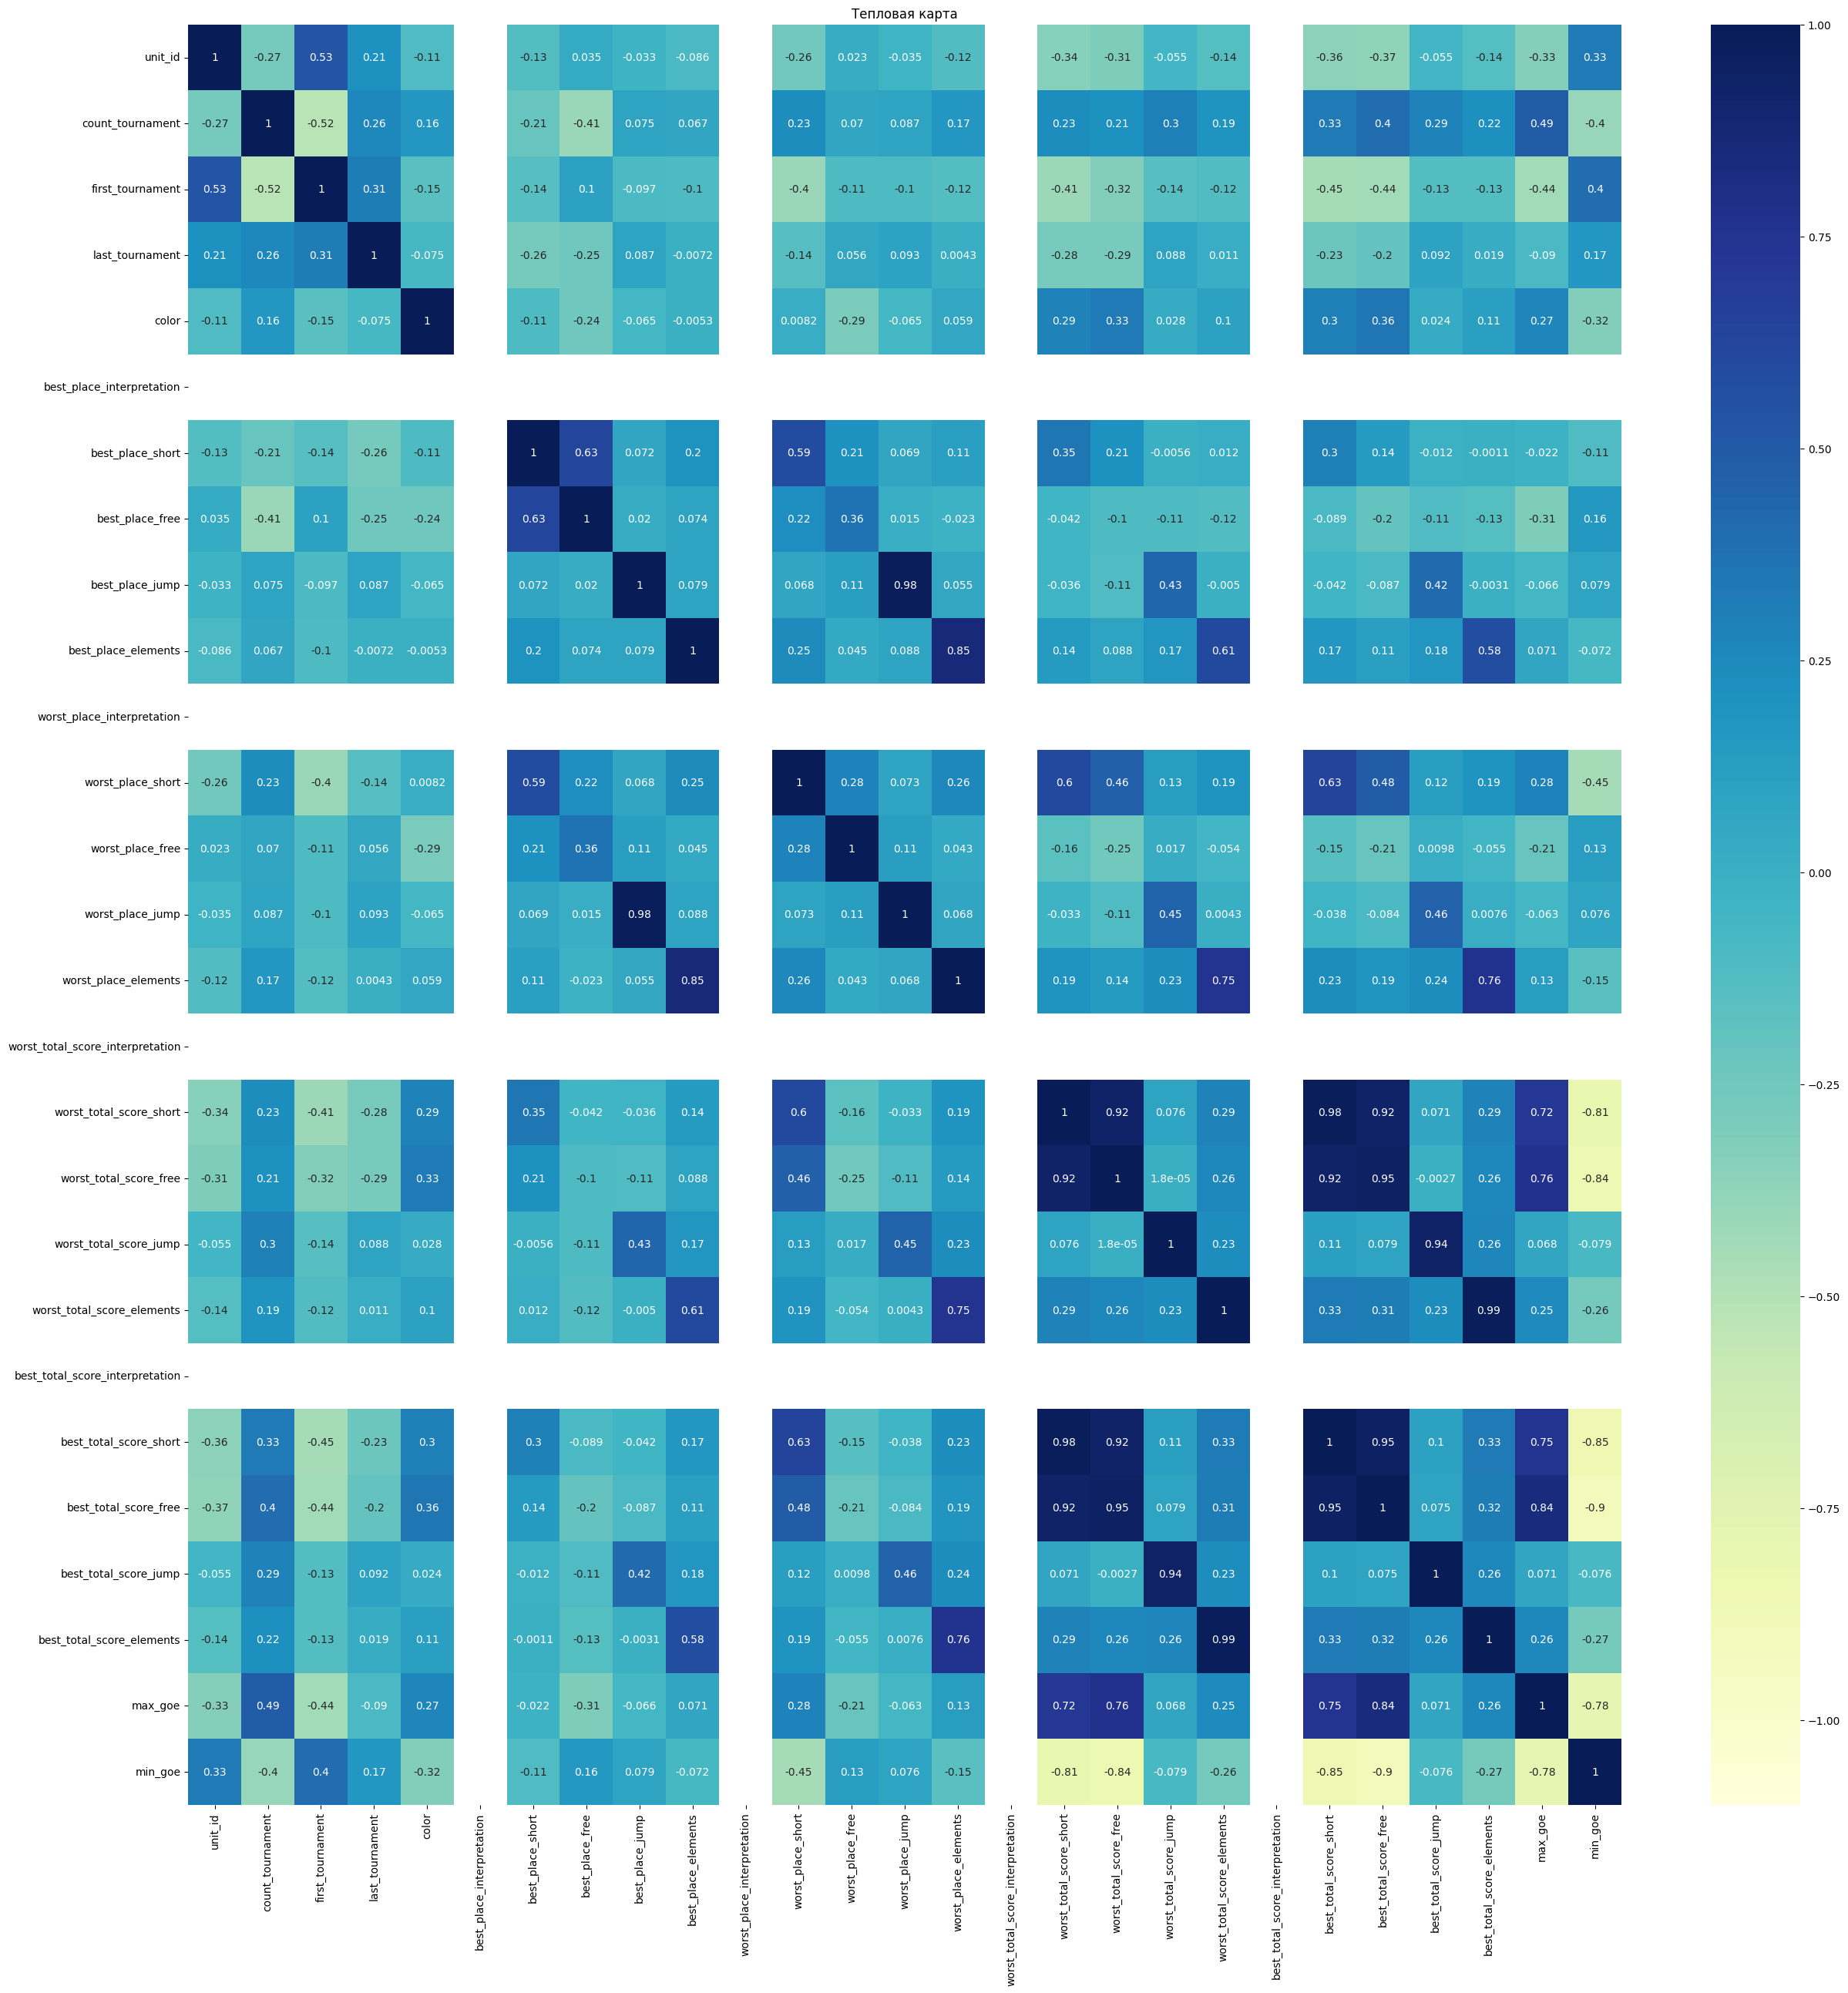

In [83]:
plt.figure(figsize=(30,30))
sns.heatmap(features.corr(), vmax=-1, vmin=1, annot=True, cmap='YlGnBu')
plt.title('Тепловая карта')
plt.show()

В датасете присутствуют коррелирующие между собой признаки - будем использовать регуляризацию.

In [84]:
target.describe()

,USp,LSp1,LSp2,LSp3,LSp4,CSp1,CSp2,CSp3,CSp4,SSp1,SSp2,SSp3,SSp4,FUSp,FLSp1,FCSp1,FCSp2,FCSp3,FCSp4,FSSp1,FSSp2,FSSp3,FSSp4,CUSp,CLSp,CCSp1,CCSp2,CCSp3,CCSp4,CSSp1,CSSp2,CSSp3,CSSp4,CoSp1,CoSp2,CCoSp1,CCoSp2,CCoSp3,CCoSp4,StSq1,StSq2,StSq3,StSq4,ChSq,1T,2T,3T,4T,1S,2S,3S,4S,1Lo,2Lo,3Lo,4Lo,1F,2F,3F,4F,1Lz,2Lz,3Lz,4Lz,1A,2A,3A,4A,1Eu
count,2291.000000,2291.000000,2291.000000,2291.000000,2291.000000,2291.000000,2291.00000,2291.000000,2291.000000,2291.000000,2291.000000,2291.000000,2291.00000,2291.0,2291.0,2291.000000,2291.000000,2291.000000,2291.000000,2291.000000,2291.000000,2291.000000,2291.000000,2291.0,2291.0,2291.00000,2291.000000,2291.000000,2291.000000,2291.000000,2291.000000,2291.000000,2291.000000,2291.000000,2291.000000,2291.000000,2291.000000,2291.000000,2291.000000,2291.000000,2291.000000,2291.000000,2291.000000,2291.000000,2291.000000,2291.000000,2291.000000,2291.000000,2291.000000,2291.000000,2291.000000,2291.000000,2291.000000,2291.000000,2291.000000,2291.000000,2291.000000,2291.000000,2291.000000,2291.000000,2291.000000,2291.000000,2291.000000,2291.000000,2291.000000,2291.000000,2291.000000,2291.0,2291.000000
mean,0.000873,0.065474,0.115234,0.202532,0.193802,0.130074,0.00742,0.003055,0.001746,0.147970,0.040157,0.042776,0.00742,0.0,0.0,0.046704,0.103012,0.166303,0.161502,0.117852,0.203841,0.251855,0.181580,0.0,0.0,0.01615,0.018333,0.041467,0.040594,0.164557,0.086425,0.088608,0.073767,0.015277,0.000436,0.189437,0.215626,0.376255,0.312091,0.333915,0.307289,0.158446,0.024880,0.484941,0.040157,0.413357,0.239633,0.025753,0.039284,0.373636,0.296377,0.020515,0.235705,0.389786,0.246617,0.002182,0.124400,0.344391,0.210825,0.003055,0.236141,0.328677,0.216499,0.007857,0.402444,0.350938,0.042340,0.0,0.231340
std,0.029540,0.247414,0.319373,0.401974,0.395362,0.336458,0.08584,0.055204,0.041757,0.355148,0.196370,0.202396,0.08584,0.0,0.0,0.211051,0.304041,0.372434,0.368073,0.322504,0.402940,0.434173,0.385582,0.0,0.0,0.12608,0.134180,0.199410,0.197390,0.370861,0.281052,0.284239,0.261448,0.122680,0.020892,0.391941,0.411346,0.484551,0.463448,0.471713,0.461471,0.365238,0.155793,0.499882,0.196370,0.492543,0.426953,0.158432,0.194313,0.483874,0.456759,0.141785,0.424531,0.487808,0.431136,0.046676,0.330109,0.475273,0.407983,0.055204,0.424803,0.469835,0.411948,0.088309,0.490498,0.477368,0.201407,0.0,0.421781
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0

In [85]:
target.sum()

USp          2
LSp1       150
LSp2       264
LSp3       464
LSp4       444
CSp1       298
CSp2        17
CSp3         7
CSp4         4
SSp1       339
SSp2        92
SSp3        98
SSp4        17
FUSp         0
FLSp1        0
FCSp1      107
FCSp2      236
FCSp3      381
FCSp4      370
FSSp1      270
FSSp2      467
FSSp3      577
FSSp4      416
CUSp         0
CLSp         0
CCSp1       37
CCSp2       42
CCSp3       95
CCSp4       93
CSSp1      377
CSSp2      198
CSSp3      203
CSSp4      169
CoSp1       35
CoSp2        1
CCoSp1     434
CCoSp2     494
CCoSp3     862
CCoSp4     715
StSq1      765
StSq2      704
StSq3      363
StSq4       57
ChSq      1111
1T          92
2T         947
3T         549
4T          59
1S          90
2S         856
3S         679
4S          47
1Lo        540
2Lo        893
3Lo        565
4Lo          5
1F         285
2F         789
3F         483
4F           7
1Lz        541
2Lz        753
3Lz        496
4Lz         18
1A         922
2A         804
3A        

Удалим из таргета элементы, которые ни разу не встречались: 4A, CLSp, CUSp, FLSp1, FUSp и 'USp', 'CSp4', '4Lo', '4F', 'CSp3', 'CoSp2', который встречался меньше 10 раз

In [86]:
target = target.drop(columns=[
                "FUSp", 'USp', 'CSp4', '4Lo', '4F', 'CSp3',
                "FLSp1",
                "CUSp", 
                "CLSp", "CoSp2",
                "4A"], axis = 1)

### Test/Train

In [87]:
# разделим на тестовую и тренировочную 
features_train, features_test, target_train, target_test = train_test_split(features, 
                                                                            target.values, test_size=0.25,
                                                                            random_state=123456)

## Модели

### DummyClassifier

Проверим данные на случайной модели

In [89]:
# Определение метрики для кросс-валидации (используем средний F1-score для каждой метки)
scorer = make_scorer(f1_score, average='micro')

In [90]:
# DummyRegressor

model_DR =  DummyClassifier(strategy= 'stratified')
clf = MultiOutputClassifier(model_DR, n_jobs=-1)
F1_DR = cross_val_score(clf, features_train, target_train, scoring =scorer, cv=5)

print(f'F1-score (micro average) на кросс-валидации: {F1_DR}')
print(f'Средний F1-score (micro average) на кросс-валидации: {F1_DR.mean()}')

F1-score (micro average) на кросс-валидации: [0.25180723 0.27111756 0.275      0.25703422 0.248     ]
Средний F1-score (micro average) на кросс-валидации: 0.2605918022263162
